## Chapter 4
# Whistler Data

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import ceil
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

from sample import Sample
from dataset import Dataset
from database import Database
from sample_detector import SampleDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_dataset = Dataset(dataset_loc, site)
my_database = Database(dataset_loc, database_loc, site)
file = np.random.choice(my_dataset.get_samples(),1)[0]

## 4.3 Simulated Data
2196 files from Marion and 375 files from Sanae

0.4113725220931104
1.6454900883724417
0.41747676690118873
1.669907067604755


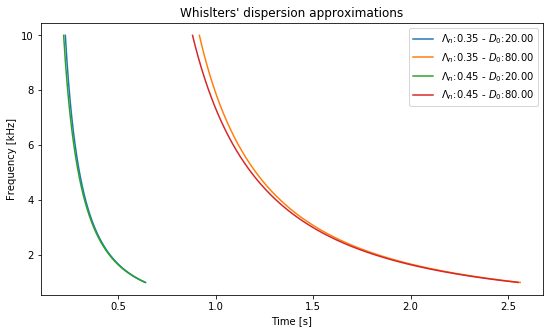

In [22]:
def whistler_trace(An, D0, fn, f):
    """generate the whistler trace
    Params
        An: normalised equatorial electron gyrofrequency
        D0: zero dispersion
        fn: nose frequency
        f: frequency range
    return
        t: time range
        """
    t = (D0/((1+An)*np.sqrt(f)))*(((1+An)-(3*An-1)*(f/fn))/(1-An*f/fn))
    return np.array(t)

An = 0.35 # 0.35 <= An <= 0.45
D0 = 20 # 20 <= D0 <= 80
fn = 25e3
f = np.linspace(1e3,10e3,1000)
legend = []
plt.figure(figsize=(9,5))
for An in np.linspace(0.35, 0.45, 2):
    for D0 in np.linspace(20,80,2):
        t = whistler_trace(An,D0,fn,f)
        print(t.max()-t.min())
        legend.append("$\Lambda_n$:%.2f - $D_0$:%.2f"%(An,D0))
        plt.plot(t,f/1e3)
plt.legend(legend)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title("Whislters' dispersion approximations" )
plt.show()

(59, 65)


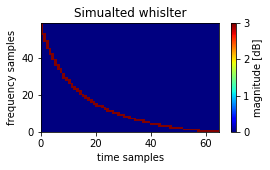

(59, 65)


In [124]:
def whistler_sim(An, D0, fn, f, t_res, f_res):
    """Generate a 2D representation of the whistler trace
    Params
        An: normalised equatorial electron gyrofrequency
        D0: zero dispersion
        fn: nose frequency
        f: frequency range
    return
        t: time range"""
    t = whistler_trace(An=An, D0=D0, fn=fn, f=f)
    t_trans, f_trans = (t-t.min())/t_res, (f-f.min())*1e-3/f_res
    t_trans, f_trans = t_trans.astype(np.int), f_trans.astype(np.int) 
    coor = np.array([(t,f) for t,f in zip(t_trans, f_trans)])
    data = np.zeros((t_trans.max()+1,f_trans.max()+1))
    for x,y in coor:
        data[x,y]=3
    return data.T

f = np.linspace(1e3,10e3,1000)
f_res, t_res = 0.15503875968992248, 0.006395061728395062 
data = whistler_sim(An=0.35, D0=20, fn=25e3, f=f, t_res=t_res, f_res=f_res)
print(data.shape)
fig = plt.figure(figsize=(2*ceil(data.shape[1]/data.shape[0]),2))
img = plt.pcolormesh(data, cmap='jet')
fig.colorbar(mappable=img, label='magnitude [dB]')
plt.xlabel('time samples')
plt.ylabel('frequency samples')
plt.title('Simualted whislter')
plt.show()
print(data.shape)

#### Generate simulated dataset

In [2]:
from dataset_simulation import DatasetSimulation
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations')
dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# dataset_sim.whistler_file(An=0.35, D0=20)
# plt.pcolormesh(dataset_sim.load_whistler_file(An=0.35, D0=20))
dataset_sim.generate_whislters()

100%|██████████| 6007001/6007001 [7:08:45<00:00, 233.50it/s]   
